https://www.kaggle.com/c/quora-insincere-questions-classification/data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
# path = Path('/Users/nikhil/workspace/fastaiv1/my_data/quora')

In [3]:
path = Path(Config.get_key('data_path')).expanduser()/'quora'
os.makedirs(path, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/quora')

In [5]:
# ! /opt/anaconda3/bin/kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p {path}
# ! /opt/anaconda3/bin/kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p {path}
# ! unzip {path}/train.csv.zip -d {path}
# ! unzip {path}/test.csv.zip -d {path}
# ! chmod 775 -R {path}

In [6]:
# df = pd.read_csv(path/'train.csv')

In [7]:
# def label(row):
#     return 'positive' if row.target else 'negative'

# df['label'] = df.apply(lambda row: label(row), axis=1)
# df = df.rename(columns = {"question_text": "text"})
# df = df.drop(['qid', 'target'], axis=1)

In [8]:
# import random
# # assign true value with probability of 0.8
# df['is_valid'] = df.apply(lambda x:0.8 > random.random(), axis=1)

#len(df) == len(df.qid.unique()) #1306122

In [9]:
# df.to_csv(path/'texts.csv', index=False, columns=['label', 'text', 'is_valid'])

In [4]:
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')

In [5]:
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103)

In [12]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


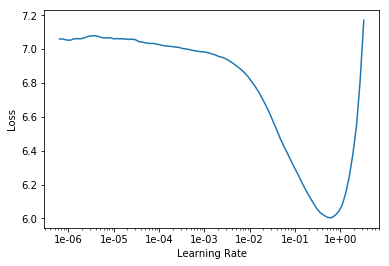

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), wd=0.03)

Total time: 1:04:37
epoch  train_loss  valid_loss  accuracy
1      3.428364    3.300545    0.450531  (1:04:37)



In [15]:
learn.save('fit_head')

In [6]:
learn.load('fit_head')

LanguageLearner(data=<fastai.text.data.TextLMDataBunch object at 0x7fda71ed4fd0>, model=SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=True)
    (output_dp): RNNDropout()
  )
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<function cross_entropy at 0x7fda72d28bf8>, metrics=[<function accuracy at 0x7fda722f3b70>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True,

In [7]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

epoch,train_loss,valid_loss,accuracy
1,3.154539,3.104321,0.469467
2,3.097028,3.036131,0.476766
3,3.035729,2.999740,0.480231
4,2.980387,2.969862,0.483182
5,2.939897,2.951534,0.485237
6,2.893694,2.937881,0.486652


RuntimeError: CUDA error: out of memory

In [8]:
learn.save('fine_tuned')

In [9]:
learn.save_encoder('fine_tuned_enc')

In [10]:
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', bs=50)

In [11]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [12]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch-nightly_1540201584778/work/aten/src/THC/generic/THCTensorMath.cu:33

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')
learn.load('first')

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/2.6,1e-2), moms=(0.8,0.7), pct_start=0.1)

In [ ]:
learn.save('second')
learn.load('second')

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**2),5e-3), moms=(0.8,0.7), pct_start=0.1)

In [ ]:
learn.save('third')
learn.load('third')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), pct_start=0.1)

In [ ]:
learn.save('fourth')